<a href="https://colab.research.google.com/github/mrinmoysh/Image-Classification/blob/master/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [0]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir('flower_data'))
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import torch

import torchvision
from torchvision import datasets, models, transforms


['train', 'valid']


Class Directory:  56


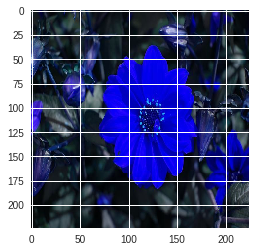

(224, 224, 3)


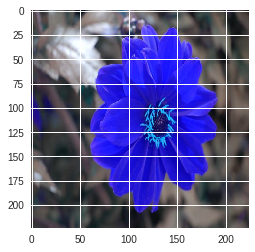

(224, 224, 3)


In [5]:
TRAIN_DATA_DIR = 'flower_data/train'
VALID_DATA_DIR = 'flower_data/valid'
#Visualiza Some Images of any Random Directory-cum-Class
FILE_DIR = str(np.random.randint(1,103))
print("Class Directory: ",FILE_DIR)
for file_name in os.listdir(os.path.join(TRAIN_DATA_DIR, FILE_DIR))[1:3]:
    img_array = cv2.imread(os.path.join(TRAIN_DATA_DIR, FILE_DIR, file_name))
    img_array = cv2.resize(img_array,(224, 224), interpolation = cv2.INTER_CUBIC)
    plt.imshow(img_array)
    plt.show()
    print(img_array.shape)

In [7]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
torch.__version__

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
classes = os.listdir(VALID_DATA_DIR)
# Load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(TRAIN_DATA_DIR, transform=data_transform)
test_data = datasets.ImageFolder(VALID_DATA_DIR, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6552
Num test images:  818


In [0]:
# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [11]:
# Load the pretrained model from pytorch
model = models.vgg16(pretrained=True)  
print(model)
print(model.classifier[6].in_features) 
print(model.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [12]:
# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False
    # VGG16  
n_inputs = model.classifier[6].in_features

#Others
# n_inputs = model.fc.in_features

# add last linear layer (n_inputs -> 102 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

# VGG16
model.classifier[6] = last_layer

# Others
#model.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

# check to see that your last layer produces the expected number of outputs

#VGG
print(model.classifier[6].out_features)

102


In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

In [19]:
# Define epochs (between 50-200)
epochs = 25
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# Some lists to keep track of loss and accuracy during each epoch
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
# Start epochs
for epoch in range(epochs):
    
    #adjust_learning_rate(optimizer, epoch)
    
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # Set the training mode ON -> Activate Dropout Layers
    model.train() # prepare model for training
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    # Load Train Images with Labels(Targets)
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        if type(output) == tuple:
            output, _ = output
        
        # Calculate Training Accuracy 
        predicted = torch.max(output.data, 1)[1]        
        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += (predicted == target).sum()
        
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average training loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Avg Accuracy
    accuracy = 100 * correct / float(total)
    
    # Put them in their list
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    
        
    # Implement Validation like K-fold Cross-validation 
    
    # Set Evaluation Mode ON -> Turn Off Dropout
    model.eval() # Required for Evaluation/Test

    # Calculate Test/Validation Accuracy         
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:


            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Predict Output
            output = model(data)
            if type(output) == tuple:
                output, _ = output

            # Calculate Loss
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
            # Get predictions from the maximum value
            predicted = torch.max(output.data, 1)[1]

            # Total number of labels
            total += len(target)

            # Total correct predictions
            correct += (predicted == target).sum()
    
    # calculate average training loss and accuracy over an epoch
    val_loss = val_loss/len(test_loader.dataset)
    accuracy = 100 * correct/ float(total)
    
    # Put them in their list
    val_acc_list.append(accuracy)
    val_loss_list.append(val_loss)
    
    # Print the Epoch and Training Loss Details with Validation Accuracy   
    print('Epoch: {} \tTraining Loss: {:.4f}\t Val. acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    # save model if validation loss has decreased
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_loss))
        # Save Model State on Checkpoint
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = val_loss
    # Move to next epoch
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 4.4249	 Val. acc: 18.00%
Validation loss decreased (inf --> 4.066440).  Saving model ...
Epoch: 2 	Training Loss: 3.8749	 Val. acc: 27.00%
Validation loss decreased (4.066440 --> 3.530404).  Saving model ...
Epoch: 3 	Training Loss: 3.3461	 Val. acc: 39.00%
Validation loss decreased (3.530404 --> 2.974557).  Saving model ...
Epoch: 4 	Training Loss: 2.8347	 Val. acc: 50.00%
Validation loss decreased (2.974557 --> 2.427473).  Saving model ...
Epoch: 5 	Training Loss: 2.3798	 Val. acc: 61.00%
Validation loss decreased (2.427473 --> 2.014410).  Saving model ...
Epoch: 6 	Training Loss: 2.0478	 Val. acc: 66.00%
Validation loss decreased (2.014410 --> 1.673652).  Saving model ...
Epoch: 7 	Training Loss: 1.7907	 Val. acc: 71.00%
Validation loss decreased (1.673652 --> 1.434155).  Saving model ...
Epoch: 8 	Training Loss: 1.5946	 Val. acc: 73.00%
Validation loss decreased (1.434155 --> 1.278068).  Saving model ...
Epoch: 9 	Training Loss: 1.4681	 Val. acc: 73.00%
Val

In [0]:
model.load_state_dict(torch.load('model.pt'))
torch.save(model, 'classifier.pth')

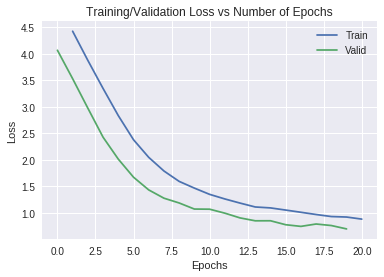

In [22]:
# Training / Validation Loss
plt.plot(epoch_list,train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Validation Loss vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

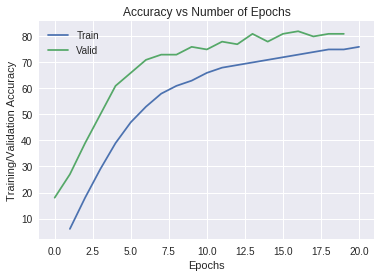

In [23]:
# Train/Valid Accuracy
plt.plot(epoch_list,train_acc_list)
plt.plot(val_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='best')
plt.show()

In [24]:
val_acc = sum(val_acc_list[:]).item()/len(val_acc_list)
print("Validation Accuracy of model = {} %".format(val_acc))

Validation Accuracy of model = 67.4 %


In [30]:
from PIL import Image
def process_image(image):
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor
    
    
    # TODO: Process a PIL image for use in a PyTorch model

img = ('flower_data/train' + '/1/' + 'image_06751.jpg')
img = process_image(img)
print(img.shape)

torch.Size([3, 224, 224])


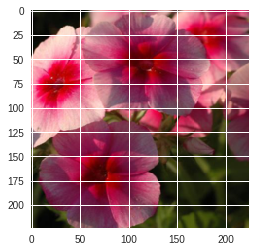

In [32]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


imshow(process_image("flower_data/train/32/image_05594.jpg"))

In [0]:
import torch.nn.functional as F
model.class_to_idx =train_data.class_to_idx

ctx = model.class_to_idx


def predict(image_path, model, topk=5):   
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)
    
    # TODO: Implement the code to predict the class from an image file

In [38]:
img = ("flower_data/train/90/image_04429.jpg")
val1, val2 = predict(img, model)
print(val1)
print(val2)

tensor([[0.8777, 0.0891, 0.0150, 0.0123, 0.0016]], device='cuda:0')
tensor([[92, 90, 43, 99, 22]], device='cuda:0')


In [0]:
import json
from matplotlib.ticker import FormatStrFormatter
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
# TODO: Display an image along with the top 5 classes
def check_sanity():
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = 1
    path = "flower_data/train/13/image_05766.jpg"

    probabilities = predict(path, model)
    image = process_image(path)
    probabilities = probabilities
    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

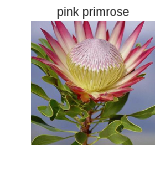

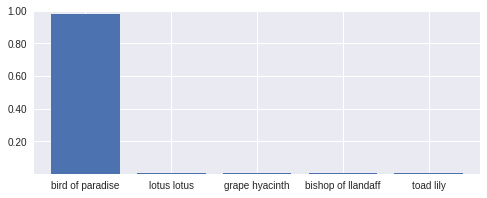

In [59]:
check_sanity()
